In [13]:
!pip install pandas openpyxl scikit-learn imbalanced-learn shap
print("✅ Libraries installed successfully.")

✅ Libraries installed successfully.


In [14]:
import pandas as pd

# The path to your CSV file
file_name = "/kaggle/input/fakejob/fake_job_postings.csv" 

# Use pd.read_csv() instead of pd.read_excel()
df = pd.read_csv(file_name)

print(f"\n✅ Successfully loaded: {file_name}")
print(df.head())


✅ Successfully loaded: /kaggle/input/fakejob/fake_job_postings.csv
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap..

In [15]:
print("--- Phase 1: Feature Engineering ---")

# a. Create "missingness" features
df['is_company_profile_missing'] = df['company_profile'].isnull().astype(int)
df['is_requirements_missing'] = df['requirements'].isnull().astype(int)
df['is_benefits_missing'] = df['benefits'].isnull().astype(int)
df['is_salary_range_missing'] = df['salary_range'].isnull().astype(int)

# b. Combine all text fields into one for analysis
text_columns = ['title', 'location', 'department', 'company_profile', 
                'description', 'requirements', 'benefits', 'function']

# Fill NaNs with empty strings to avoid errors
for col in text_columns:
    df[col] = df[col].fillna('')

df['text_combined'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)

print("✅ New features created:")
print(df[['is_company_profile_missing', 'is_salary_range_missing', 'text_combined']].head())

--- Phase 1: Feature Engineering ---
✅ New features created:
   is_company_profile_missing  is_salary_range_missing  \
0                           0                        1   
1                           0                        1   
2                           0                        1   
3                           0                        1   
4                           0                        1   

                                       text_combined  
0  Marketing Intern US, NY, New York Marketing We...  
1  Customer Service - Cloud Video Production NZ, ...  
2  Commissioning Machinery Assistant (CMA) US, IA...  
3  Account Executive - Washington DC US, DC, Wash...  
4  Bill Review Manager US, FL, Fort Worth  SpotSo...  


In [16]:
def clean_text(text):
    """
    Cleans a raw text string:
    1. Lowercases
    2. Removes HTML tags
    3. Removes punctuation and numbers
    4. Tokenizes
    5. Removes stopwords
    """
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove punctuation/numbers
    tokens = word_tokenize(text)  # Tokenize
    # Remove stop words
    cleaned_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(cleaned_tokens)

print("✅ `clean_text` function defined.")

✅ `clean_text` function defined.


In [17]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import re
import warnings

# --- NLTK for Text Processing ---
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- Scikit-learn (sklearn) for Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Imbalanced-learn (imblearn) for SMOTE ---
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- SHAP for Explainability ---
import shap

# --- Setup ---
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stop_words = set(stopwords.words('english'))

print("✅ All libraries imported and NLTK data downloaded.")

✅ All libraries imported and NLTK data downloaded.


In [19]:

print("Cleaning all text data... (This may take a moment)")
df['text_cleaned'] = df['text_combined'].apply(clean_text)
print("✅ Text cleaning complete.")
print(df[['text_combined', 'text_cleaned']].head())

Cleaning all text data... (This may take a moment)
✅ Text cleaning complete.
                                       text_combined  \
0  Marketing Intern US, NY, New York Marketing We...   
1  Customer Service - Cloud Video Production NZ, ...   
2  Commissioning Machinery Assistant (CMA) US, IA...   
3  Account Executive - Washington DC US, DC, Wash...   
4  Bill Review Manager US, FL, Fort Worth  SpotSo...   

                                        text_cleaned  
0  marketing intern new york marketing food creat...  
1  customer service cloud video production auckla...  
2  commissioning machinery assistant cma wever va...  
3  account executive washington washington sales ...  
4  bill review manager fort worth spotsource solu...  


In [20]:
print("--- Phase 2: Defining Features & Target ---")

target = 'fraudulent'

# Define which columns go into which preprocessing step
binary_features = [
    'telecommuting', 'has_company_logo', 'has_questions', 
    'is_company_profile_missing', 'is_requirements_missing', 
    'is_benefits_missing', 'is_salary_range_missing'
]
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry']
text_feature = 'text_cleaned' # Our preprocessed text

# Handle missing values in categorical features *before* splitting
df[categorical_features] = df[categorical_features].fillna('Missing')

# Create X and y
X = df[binary_features + categorical_features + [text_feature]]
y = df[target]

print(f"✅ X (features) and y (target) are defined.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

--- Phase 2: Defining Features & Target ---
✅ X (features) and y (target) are defined.
Shape of X: (17880, 12)
Shape of y: (17880,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,    # 30% of data for testing
    random_state=42,  # Ensures reproducible results
    stratify=y        # Keeps the same % of fake jobs in train and test
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: (12516, 12)
Testing set shape: (5364, 12)
Training target distribution:
fraudulent
0    0.951582
1    0.048418
Name: proportion, dtype: float64
Testing target distribution:
fraudulent
0    0.951529
1    0.048471
Name: proportion, dtype: float64


In [22]:
# This pipeline applies different transforms to different columns
preprocessor = ColumnTransformer(
    transformers=[
        # (name, transformer, columns_to_apply_to)
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), text_feature),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features) # 'passthrough' leaves these columns as-is
    ],
    remainder='drop' # Drop any columns not specified
)

print("✅ Preprocessing ColumnTransformer created.")

✅ Preprocessing ColumnTransformer created.


In [23]:
# We use ImbPipeline from imblearn to correctly handle SMOTE
# SMOTE will *only* be applied to the training data during pipeline.fit()
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)) # n_jobs=-1 uses all cores
])

# --- Train the Model ---
print("Training the model... (This may take a few minutes)")
model_pipeline.fit(X_train, y_train)
print("✅ Model training complete.")

Training the model... (This may take a few minutes)
✅ Model training complete.


In [24]:
y_pred = model_pipeline.predict(X_test)

# Pay close attention to the precision and recall for "Fake (1)"
# Precision (Fake): Of all jobs we flagged as fake, what % was *actually* fake?
# Recall (Fake): Of all *actual* fake jobs, what % did we *catch*?
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

              precision    recall  f1-score   support

    Real (0)       0.98      1.00      0.99      5104
    Fake (1)       0.98      0.70      0.82       260

    accuracy                           0.98      5364
   macro avg       0.98      0.85      0.90      5364
weighted avg       0.98      0.98      0.98      5364



In [25]:
# --- Phase 3: Setup for SHAP (FINAL FIX v5) ---
print("--- Phase 3: Setup for SHAP (FINAL FIX v5) ---")

# 1. Get fitted components
preprocessor_fitted = model_pipeline.named_steps['preprocessor']
model_fitted = model_pipeline.named_steps['model']

# 2. Get feature names
try:
    text_feature_names = preprocessor_fitted.named_transformers_['text'].get_feature_names_out()
    categorical_feature_names = preprocessor_fitted.named_transformers_['categorical'].get_feature_names_out()
except AttributeError:
    text_feature_names = preprocessor_fitted.named_transformers_['text'].get_feature_names()
    categorical_feature_names = preprocessor_fitted.named_transformers_['categorical'].get_feature_names()
    
binary_feature_names = binary_features
all_feature_names = list(text_feature_names) + list(categorical_feature_names) + list(binary_feature_names)

print(f"✅ SHAP setup complete. Total features: {len(all_feature_names)}")

# --- MODIFICATION: SAMPLE 1000 JOBS ---
print(f"Original test set has {len(X_test)} jobs. Sampling 1000 for SHAP...")
X_test_sample = X_test.sample(1000, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

print("Transforming 1000-job sample to a SPARSE matrix...")
# 3. Transform ONLY the sample. This creates a SPARSE matrix.
X_test_sample_transformed_SPARSE = preprocessor_fitted.transform(X_test_sample)

print(f"Sparse data for SHAP has shape: {X_test_sample_transformed_SPARSE.shape}")

print("\nConverting sparse data to dense DataFrame (for plotting in the next cell)...")
# 4. Create the dense DataFrame, which is used for both calculating and plotting.
X_test_sample_transformed_df = pd.DataFrame.sparse.from_spmatrix(
    X_test_sample_transformed_SPARSE, 
    columns=all_feature_names, 
    index=X_test_sample.index
).sparse.to_dense()

print(f"Dense DataFrame for SHAP has shape: {X_test_sample_transformed_df.shape}")

# --- THE FIX ---
# We initialize the explainer with feature_perturbation="interventional".
# This uses a different, more robust method that avoids the np.isnan bug.
print("Initializing SHAP Explainer with 'interventional' perturbation...")
explainer = shap.TreeExplainer(model_fitted, feature_perturbation="interventional")

print("Calculating SHAP values from the Dense DataFrame...")
# We pass the clean Dense DataFrame to the new explainer.
shap_values_sample = explainer.shap_values(X_test_sample_transformed_df, check_additivity=False)
print("✅ SHAP values calculated.")

--- Phase 3: Setup for SHAP (FINAL FIX v5) ---
✅ SHAP setup complete. Total features: 5165
Original test set has 5364 jobs. Sampling 1000 for SHAP...
Transforming 1000-job sample to a SPARSE matrix...
Sparse data for SHAP has shape: (1000, 5165)

Converting sparse data to dense DataFrame (for plotting in the next cell)...
Dense DataFrame for SHAP has shape: (1000, 5165)
Initializing SHAP Explainer with 'interventional' perturbation...
Calculating SHAP values from the Dense DataFrame...
✅ SHAP values calculated.



--- SHAP Summary Plot (from 1000-job sample) ---
SHAP values (Class 0) shape: (1000, 5165)
SHAP values (Class 1) shape: (1000, 5165)
Data shape: (1000, 5165)


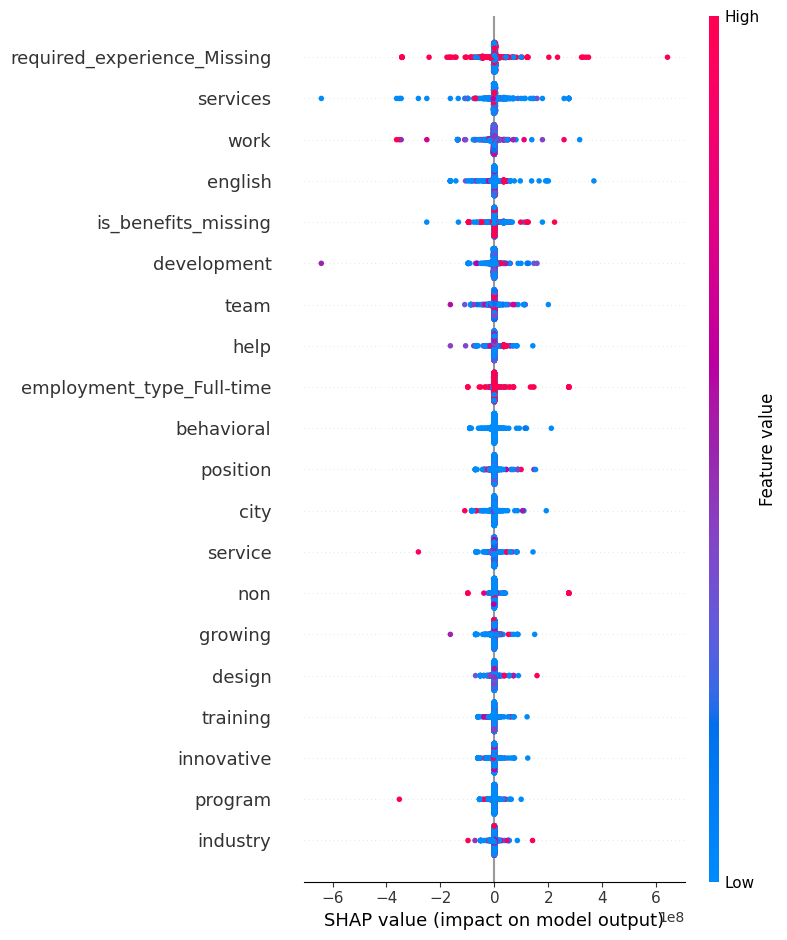

In [26]:
# --- Modified Cell 15 (FINAL FIX v5) ---
print("\n--- SHAP Summary Plot (from 1000-job sample) ---")

# Check the shape of the new SHAP values. 
# It should now be a list of two arrays, each (1000, 5165)
print(f"SHAP values (Class 0) shape: {shap_values_sample[0].shape}")
print(f"SHAP values (Class 1) shape: {shap_values_sample[1].shape}")
print(f"Data shape: {X_test_sample_transformed_df.shape}")

# If the second numbers match (e.g., 5165), this will work.
shap.summary_plot(
    shap_values_sample[1], 
    X_test_sample_transformed_df,  # <-- Pass the DataFrame for plotting
    max_display=20, 
    show=True
)

In [28]:
print("--- Phase 4: Defining User Personas ---")

USER_PERSONAS = {
    'new_graduate': {
        'name': 'New Graduate',
        'vulnerable_to': ['entry level', 'internship', 'no experience'],
        'keywords': ['urgent', 'no experience', 'apply now']
    },
    'mid_career': {
        'name': 'Mid-Career Professional',
        'vulnerable_to': ['senior', 'manager', 'director'],
        'keywords': ['too good to be true', 'high salary', 'vague responsibilities']
    },
    'career_switcher': {
        'name': 'Career Switcher',
        'vulnerable_to': ['entry level', 'training provided', 'flexible'],
        'keywords': ['vague requirements', 'work from home']
    }
}

print(f"✅ Defined {len(USER_PERSONAS)} personas.")

--- Phase 4: Defining User Personas ---
✅ Defined 3 personas.


In [30]:
print("--- Phase 4: Defining Personalization Function ---")

def get_alert_by_original_index(original_df_index, persona_key):
    """
    Analyzes a single job from the TEST set and provides a personalized alert.
    
    Args:
        original_df_index (int): The original index of the job from the main 'df'.
        persona_key (str): 'new_graduate', 'mid_career', etc.
    """
    
    # Find the job's *position* (0, 1, 2...) in our 1000-job sample
    try:
        job_index_in_sample = X_test_sample.index.get_loc(original_df_index)
    except KeyError:
        print(f"Error: Job index {original_df_index} not found in our 1000-job sample.")
        return

    # --- 1. Get Job Data ---
    # Get the specific job's original data
    job_data_original = X_test_sample.iloc[[job_index_in_sample]] 
    job_title = df.loc[job_data_original.index, 'title'].values[0]
    
    # --- 2. Get Model Prediction ---
    risk_score = model_pipeline.predict_proba(job_data_original)[0][1] # Probability of 'fake'
    prediction = "FAKE" if risk_score > 0.5 else "REAL"
    
    # --- 3. Get SHAP Explanation ---
    # Get the SHAP explanation data for this one job
    # We use the positional index on the SHAP values array
    job_shap_values = shap_values_sample[1][job_index_in_sample] # Get class 1 SHAP values
    
    # Find top 3 red flags (positive SHAP values)
    shap_series = pd.Series(job_shap_values, index=all_feature_names)
    top_red_flags = shap_series[shap_series > 0].nlargest(3).index.tolist()
    top_green_flags = shap_series[shap_series < 0].nsmallest(3).abs().index.tolist()

    # --- 4. Build the Alert ---
    persona = USER_PERSONAS[persona_key]
    alert_message = f"--- Personalized Alert for {persona['name']} ---\n\n"
    alert_message += f"**Job Title:** '{job_title}'\n"
    
    if prediction == "FAKE":
        alert_message += f"🚨 **WARNING!** This job has a **{risk_score:.0%} risk score** of being FAKE.\n"
        if top_red_flags:
            alert_message += "\n**Top Red Flags:**\n"
            for flag in top_red_flags:
                # Clean up feature names for readability
                flag_clean = flag.replace('is_', '').replace('_missing', ' is missing').replace('employment_type_', 'Type: ').replace('text_', 'Keyword: ')
                alert_message += f"* {flag_clean}\n"
    else: # If prediction == "REAL"
        alert_message += f"✅ **Looks Safe.** This job has a very low risk score ({risk_score:.0%}).\n"
        if top_green_flags:
            alert_message += "\n**Top Trust Signals:**\n"
            for flag in top_green_flags:
                flag_clean = flag.replace('has_', 'Has ').replace('has_questions', 'Has interview questions').replace('text_', 'Keyword: ')
                alert_message += f"* {flag_clean}\n"
    return alert_message

print("✅ `get_personalized_alert` function defined.")

--- Phase 4: Defining Personalization Function ---
✅ `get_personalized_alert` function defined.


In [32]:
print("--- Phase 4: Running Personalization Engine (on Sampled Data) ---")

# --- First, let's find an "ambiguous" job ---
print("\n--- 🔍 Searching for an Ambiguous Job (30%-70% Risk) ---")

# Get the risk scores for ALL jobs in our 1000-job sample
all_risk_scores_proba = model_pipeline.predict_proba(X_test_sample)
# Get just the probability of 'fake' (class 1)
risk_scores_fake = all_risk_scores_proba[:, 1]

# Create a Series with the original index and the risk score
risk_series = pd.Series(risk_scores_fake, index=X_test_sample.index)

# Find jobs with a risk score between 30% and 70%
ambiguous_jobs = risk_series[(risk_series > 0.3) & (risk_series < 0.7)]

if not ambiguous_jobs.empty:
    # Get the original index of the first ambiguous job
    ambiguous_job_index = ambiguous_jobs.index[0]
    print(f"Found an ambiguous job (Index: {ambiguous_job_index}) with {ambiguous_jobs.iloc[0]:.0%} risk.")
    
    print("\n--- 🧐 Example Alert for an AMBIGUOUS Job ---")
    alert_ambiguous = get_alert_by_original_index(ambiguous_job_index, 'career_switcher')
    print(alert_ambiguous)
else:
    print("\nNo ambiguous jobs (30-70% risk) were found in the 1000-job sample.")

# --- Now we run the original examples for comparison ---

# Find the original index of the first FAKE job *in our sample*
try:
    first_fake_job_original_index = y_test_sample[y_test_sample == 1].index[0]
    print("\n--- 🔔 Example Alert for a CLEARLY FAKE Job ---")
    alert_1 = get_alert_by_original_index(first_fake_job_original_index, 'new_graduate')
    print(alert_1)
except IndexError:
    print("\nNo fake jobs found in the 1000-job sample to demonstrate alert.")

# Find the original index of the first REAL job *in our sample*
try:
    first_real_job_original_index = y_test_sample[y_test_sample == 0].index[0]
    print("\n--- ✅ Example Alert for a CLEARLY REAL Job ---")
    alert_2 = get_alert_by_original_index(first_real_job_original_index, 'mid_career')
    print(alert_2)
except IndexError:
    print("\nNo real jobs found in the 1000-job sample to demonstrate alert.")

print("\n\n--- 🎉 Project Complete ---")

--- Phase 4: Running Personalization Engine (on Sampled Data) ---

--- 🔍 Searching for an Ambiguous Job (30%-70% Risk) ---
Found an ambiguous job (Index: 1878) with 38% risk.

--- 🧐 Example Alert for an AMBIGUOUS Job ---
--- Personalized Alert for Career Switcher ---

**Job Title:** 'KMC '
✅ **Looks Safe.** This job has a very low risk score (38%).

**Top Trust Signals:**
* program
* services
* work


--- 🔔 Example Alert for a CLEARLY FAKE Job ---
--- Personalized Alert for New Graduate ---

**Job Title:** 'Home Based Payroll Typist/Data Entry Clerks Positions Available'
🚨 **WARNING!** This job has a **100% risk score** of being FAKE.

**Top Red Flags:**
* position
* training
* earn


--- ✅ Example Alert for a CLEARLY REAL Job ---
--- Personalized Alert for Mid-Career Professional ---

**Job Title:** 'Front-end Developer'
✅ **Looks Safe.** This job has a very low risk score (0%).

**Top Trust Signals:**
* required_experience_Missing
* english
* work



--- 🎉 Project Complete ---


In [33]:
print("--- 🕵️‍♂️ Investigating the Ambiguous Job ---")

# We need the index variable from the previous cell.
# Make sure you've run the cell that defines 'ambiguous_job_index'.
try:
    job_to_inspect_index = ambiguous_job_index
    print(f"Inspecting original data for job index: {job_to_inspect_index}\n")
    
    # Get the full row from the original DataFrame 'df'
    job_details = df.loc[job_to_inspect_index]
    
    # Print the key text columns
    print(f"**Title:** {job_details['title']}\n")
    print(f"**Company Profile:** {job_details['company_profile']}\n")
    print(f"**Description:** {job_details['description']}\n")
    print(f"**Requirements:** {job_details['requirements']}\n")
    print(f"**Benefits:** {job_details['benefits']}\n")
    print(f"**Function:** {job_details['function']}\n")
    
    print("\n--- Full Combined Text (what the model analyzed) ---")
    print(job_details['text_combined'])
    
except NameError:
    print("ERROR: 'ambiguous_job_index' is not defined.")
    print("Please re-run the previous cell (Cell 18) to find the job first, then run this cell again.")

--- 🕵️‍♂️ Investigating the Ambiguous Job ---
Inspecting original data for job index: 1878

**Title:** KMC 

**Company Profile:** 

**Description:** This is for the KMC project.We are looking for someone who is reliable and has the ability to work between 8-11 hours each week.  This would include potentially over Christmas break, but we will manage the program so that the workers can split the break in half and only work for part of the break (although for increased hours during that ten day span).  We will give preference to those with PCs but it is not a deal breaker.

**Requirements:** 

**Benefits:** 

**Function:** 


--- Full Combined Text (what the model analyzed) ---
KMC     This is for the KMC project.We are looking for someone who is reliable and has the ability to work between 8-11 hours each week.  This would include potentially over Christmas break, but we will manage the program so that the workers can split the break in half and only work for part of the break (although 